# Image Processing - Assignment 2

In [1]:
#Importing useful packages
import cv2 as cv
from scipy.fftpack import fft2, fftshift, ifft2, ifftshift
from skimage.measure import compare_mse, compare_psnr
from scipy.special import j1 as bessel1D
import scipy.stats as st

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from math import log
import os

import warnings
warnings.filterwarnings("ignore")

###Reading an Image

In [18]:
# read an image, divide each pixel valuesby 255 reamin with floating point pixel values (in range 0-1)
image = cv.imread('15004.jpg')
print('Image size is', image.shape, 'and data type is', image.dtype)
image = cv.imread('2092.jpg')
print('Image size is', image.shape, 'and data type is', image.dtype)

Image size is (481, 321, 3) and data type is uint8
Image size is (321, 481, 3) and data type is uint8


### Gaussian Defocus Blur
Gaussian kernal with size 15

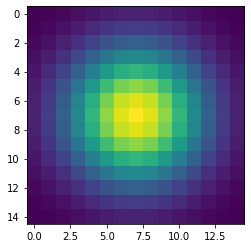

In [3]:
#defining a gaussian kernel to defocus the images
def gaussian_kernel(klen=15, nsig=3):    
    irange = (2*nsig+1.)/(klen)
    x = np.linspace(-nsig-irange/2., nsig+irange/2., klen+1)
    kernel = np.diff(st.norm.cdf(x))
    kernel = np.sqrt(np.outer(kernel, kernel))
    kernel = kernel/kernel.sum()
    return kernel

plt.imshow(gaussian_kernel())

### Function to add defocus blur

In [4]:
#Blurring an image in frequency domain using fourier transform and inverse fourier transform
def blur_image(image, klen = 15, nsig = 3):
    image2 = np.array(image)
    h = gaussian_kernel(klen, nsig)
    h = np.fft.fft2(h, image.shape)

    image2 = np.fft.fft2(image2)
    image2 = image2 * h
    image2 = np.fft.ifft2(image2).real
    return(image2)

### Inverse filter

In [5]:
#Deblurring an image in frequency domain using fourier transform and inverse fourier transform using naive inverse filter
def deblur_inverse(image2):
    image3 = np.fft.fft2(image2)
    h = gaussian_kernel()
    h = np.fft.fft2(h, image2.shape)
    image3 = image3 / h
    image3 = np.fft.ifft2(image3).real
    return(image3)

### Wiener filter

In [6]:
#Deblurring an image in frequency domain using fourier transform and inverse fourier transform using wiener filter
def deblur_wiener(image2, k):
    h = gaussian_kernel()
    h = np.fft.fft2(h, image2.shape)
    hh = (1/h)*(np.abs(h)**2)/((np.abs(h)**2) + k)
    image4 = np.fft.fft2(image2)
    image4 = image4 * hh
    image4 = np.fft.ifft2(image4).real
    return(image4)

### Function to add additive gaussian noise

In [7]:
#Gaussian additive noise
def noise(image2, sigma = 0.01):
    img_shape_y, img_shape_x = image2.shape
    mean = 0
    gauss_noise = np.random.normal(mean,sigma,(img_shape_y,img_shape_x,1))
    gauss_noise = gauss_noise.reshape(img_shape_y,img_shape_x)
    return(gauss_noise)

### Deblurring Image (no noise) 

MSE(original image, blurred image): 0.0056725659659007605
MSE(original image, image deblurred with inverse filter): 1.2537074504419887e-20
MSE(original image, image deblurred with wiener filter): 0.0011033222948170838

PSNR(original image, blurred image:) 70.6270037565507
PSNR(original image, image deblurred with inverse filter:) 247.18283723858895
PSNR(original image, image deblurred with wiener filter:) 77.73777536574299
MSE(original image, blurred image): 0.037886790391461554
MSE(original image, image deblurred with inverse filter): 9.196519533621402e-21
MSE(original image, image deblurred with wiener filter): 0.0046506718147547735

PSNR(original image, blurred image:) 62.379921153808766
PSNR(original image, image deblurred with inverse filter:) 248.52856432988222
PSNR(original image, image deblurred with wiener filter:) 71.48964237009811


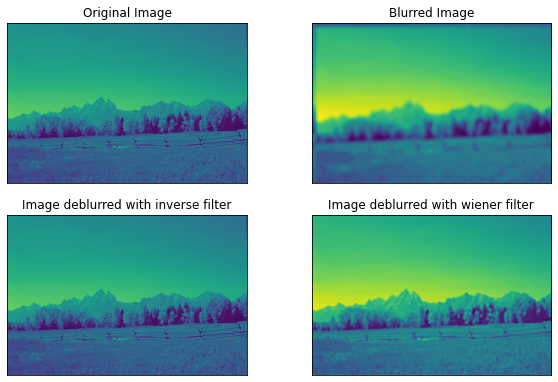

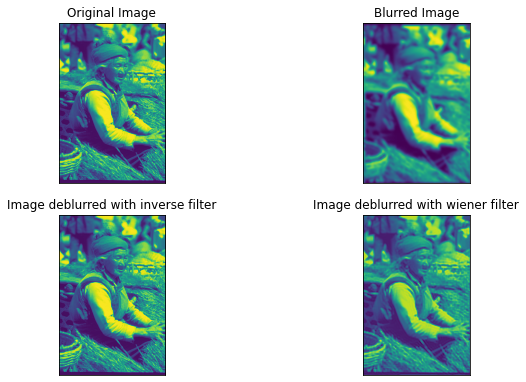

In [22]:
for imagefile in filter(lambda x: x.endswith('.jpg'), os.listdir('.')):
    #Reading the image
    image = cv.imread(imagefile)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255
    #Blurring the image
    blur_img = blur_image(image)
    #Deblurring with inverse filter
    deblur_inv = deblur_inverse(blur_img)
    #Deblurring with wiener filter
    deblur_w = deblur_wiener(blur_img, 0.0001)
    #Plotting images
    plt.rcParams['figure.figsize']=(10,10)

    fig = plt.figure()

    fig_orgl = fig.add_subplot(321)
    fig_orgl.set_title('Original Image')
    fig_orgl.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_orgl.imshow(image)

    fig_blur = fig.add_subplot(322)
    fig_blur.set_title('Blurred Image')
    fig_blur.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_blur.imshow(blur_img)

    fig_deblur_inv = fig.add_subplot(323)
    fig_deblur_inv.set_title('Image deblurred with inverse filter')
    fig_deblur_inv.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_inv.imshow(deblur_inv)

    fig_deblur_w = fig.add_subplot(324)
    fig_deblur_w.set_title('Image deblurred with wiener filter')
    fig_deblur_w.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_w.imshow(deblur_w)



    #calculating MSE and PSNR
    print("MSE(original image, blurred image):", compare_mse(np.abs(image), np.abs(blur_img)))
    print("MSE(original image, image deblurred with inverse filter):", compare_mse(np.abs(image), np.abs(deblur_inv)))
    print("MSE(original image, image deblurred with wiener filter):", compare_mse(np.abs(image), np.abs(deblur_w)))
    print()
    print("PSNR(original image, blurred image:)", compare_psnr(np.abs(image), np.abs(blur_img), 256))
    print("PSNR(original image, image deblurred with inverse filter:)", compare_psnr(np.abs(image), np.abs(deblur_inv), 256))
    print("PSNR(original image, image deblurred with wiener filter:)", compare_psnr(np.abs(image), np.abs(deblur_w), 256))


In [13]:
#calculating the noise to signal ratio
def NSR(image, noise):
    N = np.abs(fft2(noise))**2
    S = np.abs(fft2(image))**2
    NSR = N/S
    return(NSR)

### Deblurring image (noise)

MSE(original image, blurred image): 0.0056725659659007605
MSE(original image, image deblurred with inverse filter): 83881061.43864584
MSE(original image, image deblurred with wiener filter(known NSR)): 0.0017246000150941668
MSE(original image, image deblurred with wiener filter(unknown NSR)): 0.0022089353514753757

PSNR(original image, blurred image): 70.6270037565507
PSNR(original image, image deblurred with inverse filter): -31.0718398680659
PSNR(original image, image deblurred with wiener filter(known NSR)): 74.72296924986922
PSNR(original image, image deblurred with wiener filter(unknown NSR)): 74.72296924986922
MSE(original image, blurred image): 0.037886790391461554
MSE(original image, image deblurred with inverse filter): 85352601.8452146
MSE(original image, image deblurred with wiener filter(known NSR)): 0.006576370241237915
MSE(original image, image deblurred with wiener filter(unknown NSR)): 0.009324767299791401

PSNR(original image, blurred image): 62.379921153808766
PSNR(or

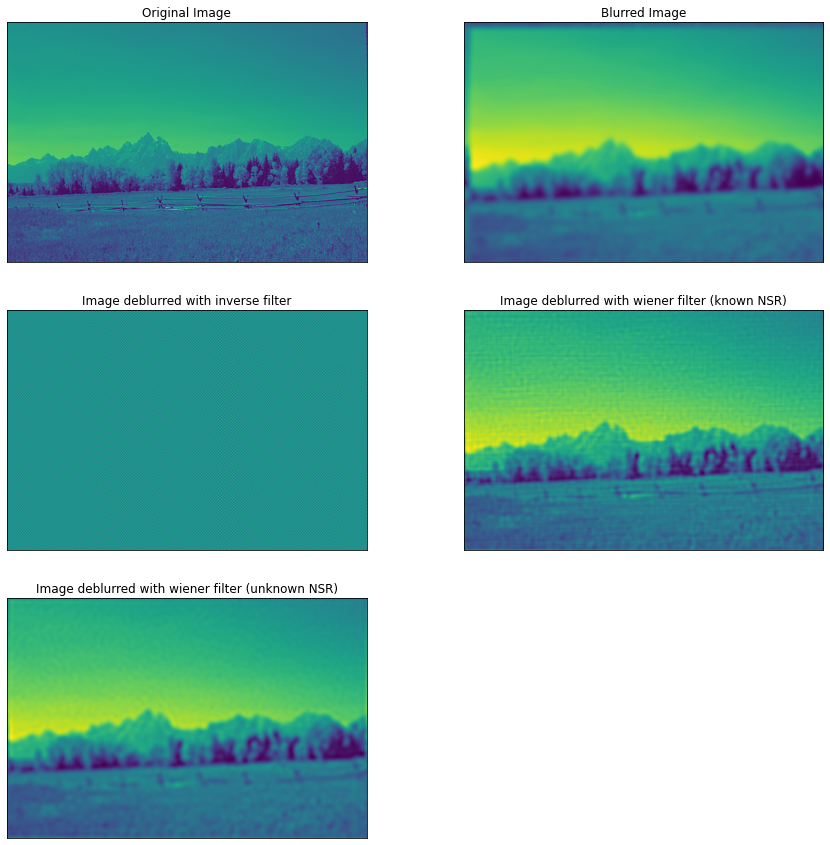

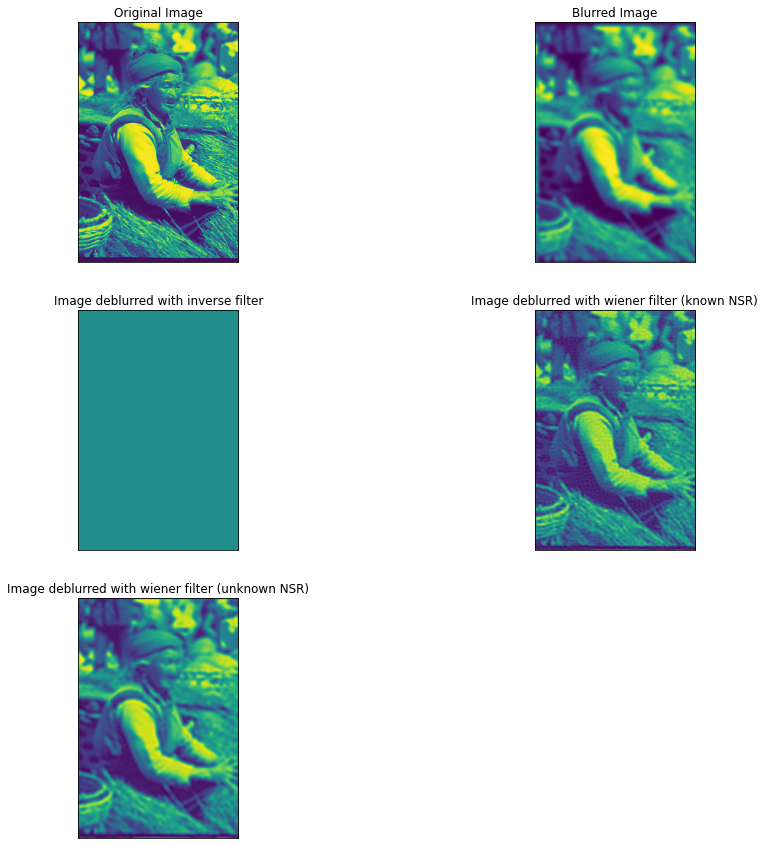

In [34]:
for imagefile in filter(lambda x: x.endswith('.jpg'), os.listdir('.')):

    #Reading the images
    image = cv.imread(imagefile)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255
    #blurring the image
    blur_img = blur_image(image)

    #gaussian additive noise
    noise_ = noise(blur_img)

    #adding noise to image
    noisy_img = blur_img + noise_

    #deblurring using inverse filter
    deblur_inv = deblur_inverse(noisy_img)

    #deblurring using weiner filter
    nsr = NSR(image, noise_)
    deblur_w_nsr = deblur_wiener(noisy_img, nsr)
    deblur_w = deblur_wiener(noisy_img, 0.042) 

    #plotting images
    plt.rcParams['figure.figsize']=(15,15)

    fig = plt.figure()

    fig_orgl = fig.add_subplot(321)
    fig_orgl.set_title('Original Image')
    fig_orgl.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_orgl.imshow(image)

    fig_blur = fig.add_subplot(322)
    fig_blur.set_title('Blurred Image')
    fig_blur.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_blur.imshow(blur_img)

    fig_deblur_inv = fig.add_subplot(323)
    fig_deblur_inv.set_title('Image deblurred with inverse filter')
    fig_deblur_inv.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_inv.imshow(deblur_inv)

    fig_deblur_w = fig.add_subplot(324)
    fig_deblur_w.set_title('Image deblurred with wiener filter (known NSR)')
    fig_deblur_w.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_w.imshow(deblur_w_nsr)

    fig_deblur_w = fig.add_subplot(325)
    fig_deblur_w.set_title('Image deblurred with wiener filter (unknown NSR)')
    fig_deblur_w.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_w.imshow(deblur_w)

    #calculating MSE and PSNR
    print("MSE(original image, blurred image):", compare_mse(np.abs(image), np.abs(blur_img)))
    print("MSE(original image, image deblurred with inverse filter):", compare_mse(np.abs(image), np.abs(deblur_inv)))
    print("MSE(original image, image deblurred with wiener filter(known NSR)):", compare_mse(np.abs(image), np.abs(deblur_w_nsr)))
    print("MSE(original image, image deblurred with wiener filter(unknown NSR)):", compare_mse(np.abs(image), np.abs(deblur_w)))
    print()
    print("PSNR(original image, blurred image):", compare_psnr(np.abs(image), np.abs(blur_img), 256))
    print("PSNR(original image, image deblurred with inverse filter):", compare_psnr(np.abs(image), np.abs(deblur_inv), 256))
    print("PSNR(original image, image deblurred with wiener filter(known NSR)):", compare_psnr(np.abs(image), np.abs(deblur_w),256))
    print("PSNR(original image, image deblurred with wiener filter(unknown NSR)):", compare_psnr(np.abs(image), np.abs(deblur_w),256))


In [36]:
import skimage.io
import skimage.filters
import sys

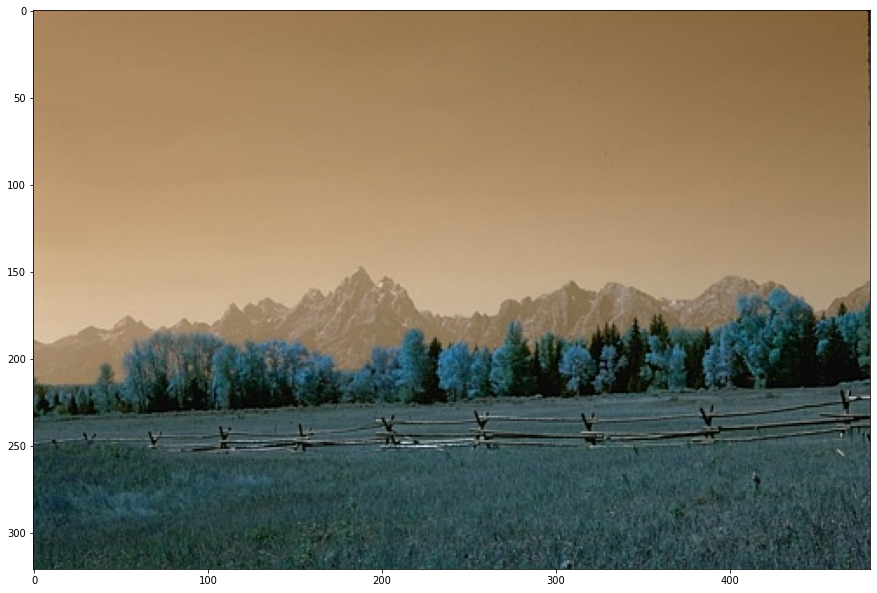

In [49]:
# read and display original image
image = cv.imread('2092.jpg')
plt.imshow(image)
plt.show()


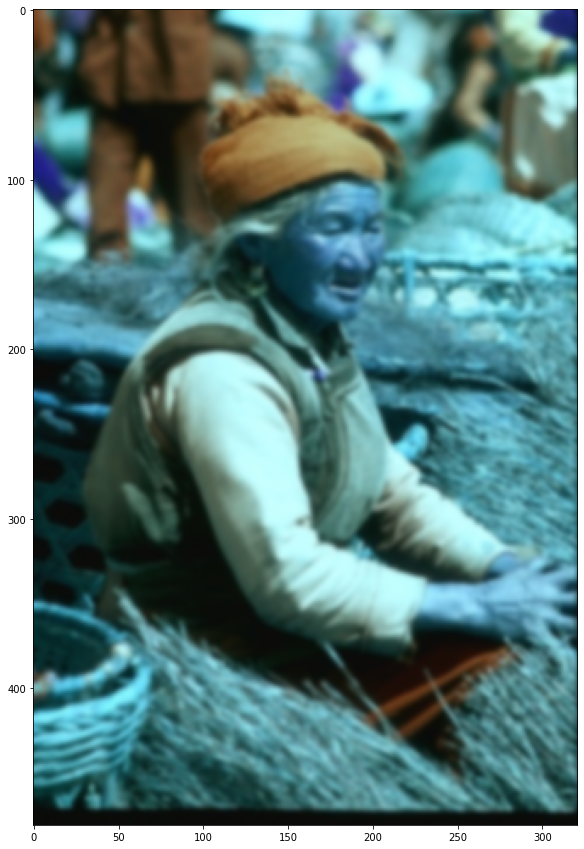

In [61]:
#Intensity of Blurness can be incresed by increasing sigma value
blurred = skimage.filters.gaussian(
    image, (1.5, 1.5), truncate=3.5, multichannel=True)
plt.imshow(blurred)

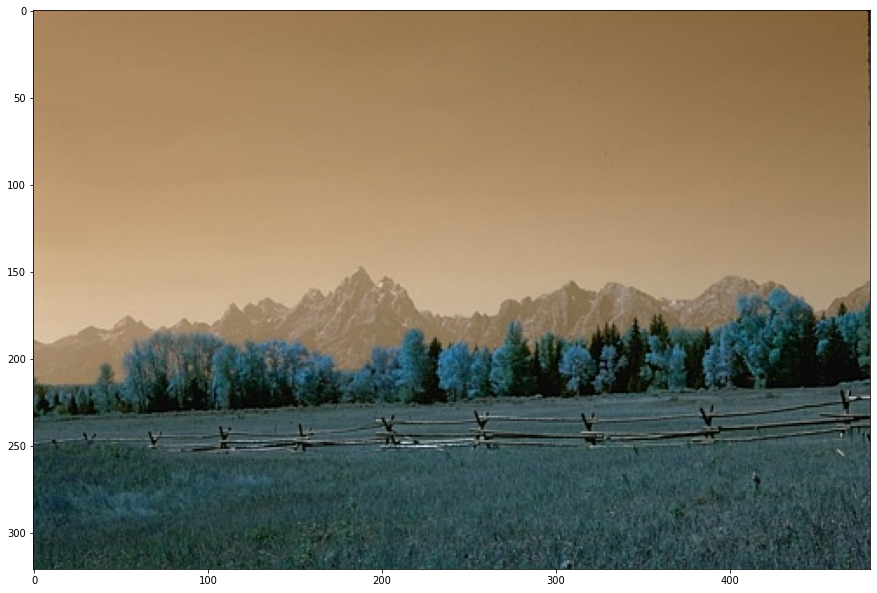

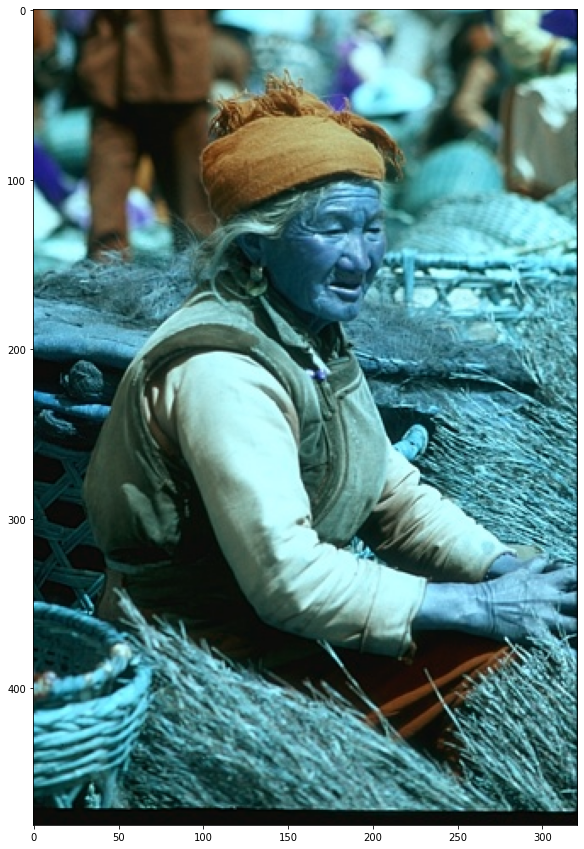

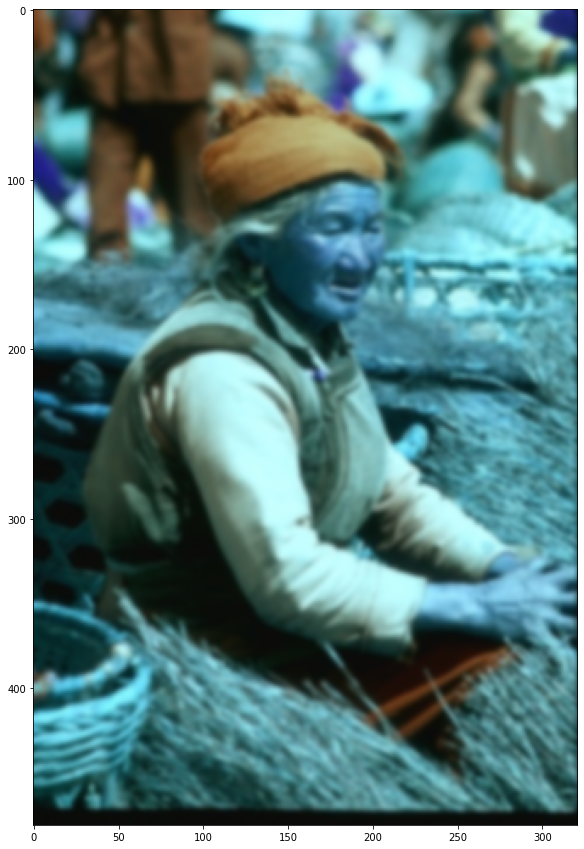

In [60]:
for imagefile in filter(lambda x: x.endswith('.jpg'), os.listdir('.')):
  image = cv.imread(imagefile)
  plt.imshow(image)
  plt.show()

  blurred = skimage.filters.gaussian(image, (1.5, 1.5), truncate=3.5, multichannel=True)
  plt.imshow(blurred)


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from skimage.io import imread
from glob import glob

from keras.layers import Conv2D, BatchNormalization, Activation
from keras.models import Model, Input
import keras.backend as K

In [87]:
Images = []; Blurry = []
for imagefile in filter(lambda x: x.endswith('.jpg'), os.listdir('.')):
    image = cv.imread(imagefile)    
    Images.append(image)
    blurry = skimage.filters.gaussian(image, (1.5, 1.5), truncate=3.5, multichannel=True)
    newsize=(64,64,3)
    blurry = blurry.resize(newsize)
    Blurry.append(blurry)
Images = np.array(Images)
Blurry = np.array(Blurry)

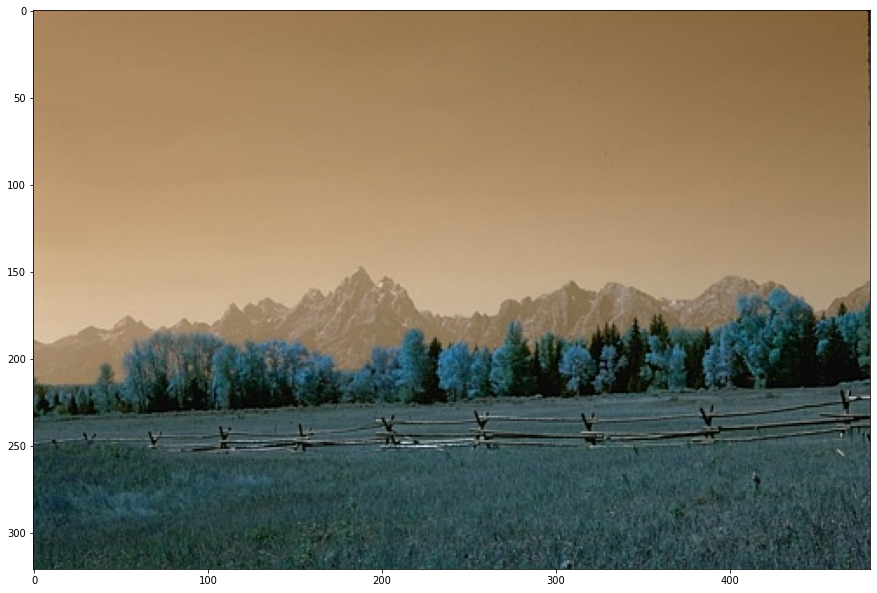

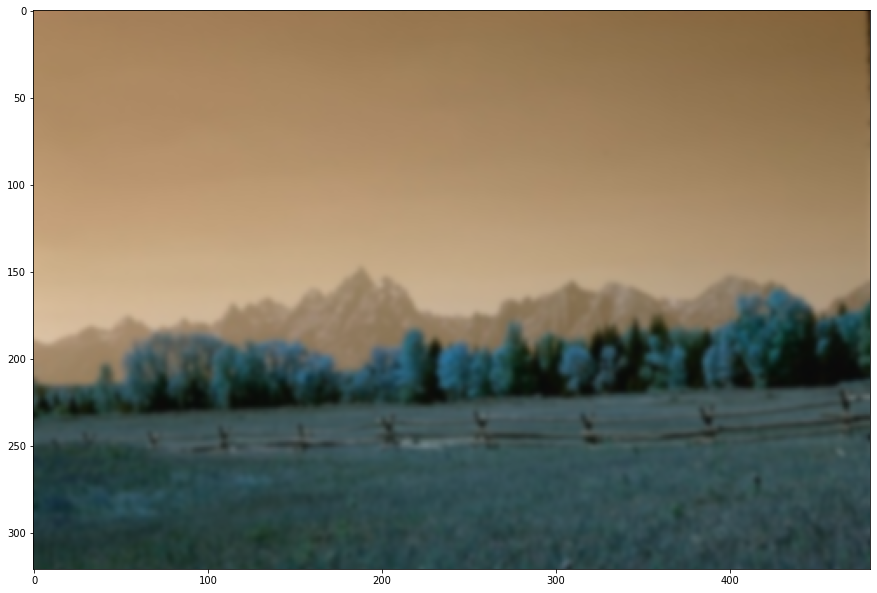

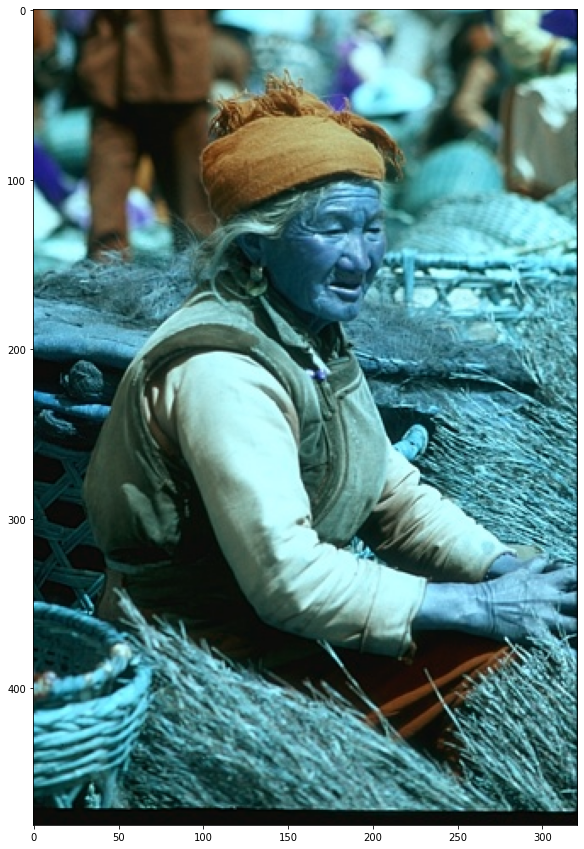

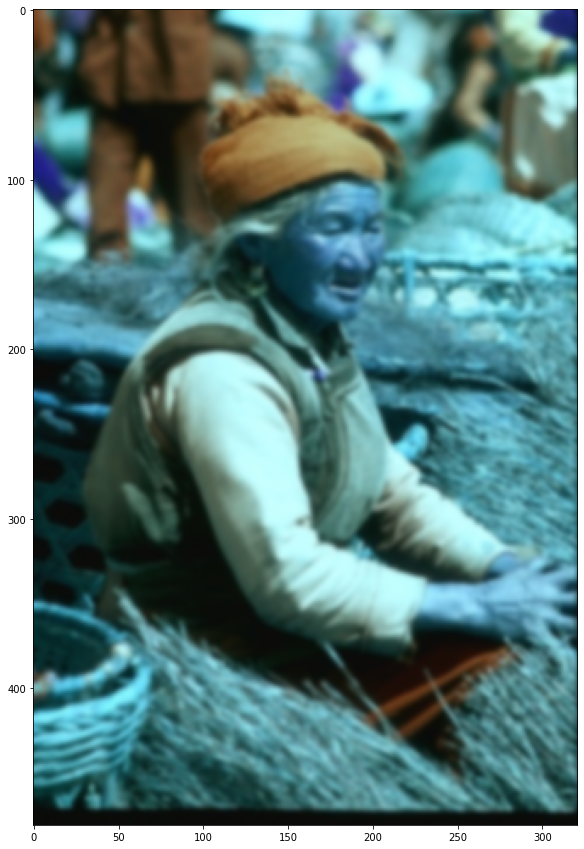

In [74]:
for i in range(2):
    plt.imshow(Images[i])
    plt.show()
    plt.imshow(Blurry[i])
    plt.show()

In [75]:
deblur_CNN_input = Input(shape=(64,64,3))

#HIDDEN LAYERS
deblur_CNN_layer1 = Conv2D(filters=128, kernel_size=10, strides = 1, padding='same')(deblur_CNN_input)
deblur_CNN_layer1 = BatchNormalization()(deblur_CNN_layer1)
deblur_CNN_layer1 = Activation('relu')(deblur_CNN_layer1)

deblur_CNN_layer2 = Conv2D(filters=320, kernel_size=1, strides = 1, padding='same')(deblur_CNN_layer1)
deblur_CNN_layer2 = BatchNormalization()(deblur_CNN_layer2)
deblur_CNN_layer2 = Activation('relu')(deblur_CNN_layer2)

deblur_CNN_layer3 = Conv2D(filters=320, kernel_size=1, strides = 1, padding='same')(deblur_CNN_layer2)
deblur_CNN_layer1 = BatchNormalization()(deblur_CNN_layer3)
deblur_CNN_layer1 = Activation('relu')(deblur_CNN_layer3)

deblur_CNN_layer4 = Conv2D(filters=320, kernel_size=1, strides = 1, padding='same')(deblur_CNN_layer3)
deblur_CNN_layer4 = BatchNormalization()(deblur_CNN_layer4)
deblur_CNN_layer4 = Activation('relu')(deblur_CNN_layer4)

deblur_CNN_layer5 = Conv2D(filters=128, kernel_size=1, strides = 1, padding='same')(deblur_CNN_layer4)
deblur_CNN_layer5 = BatchNormalization()(deblur_CNN_layer5)
deblur_CNN_layer5 = Activation('relu')(deblur_CNN_layer5)

deblur_CNN_layer6 = Conv2D(filters=128, kernel_size=3, strides = 1, padding='same')(deblur_CNN_layer5)
deblur_CNN_layer6 = BatchNormalization()(deblur_CNN_layer6)
deblur_CNN_layer6 = Activation('relu')(deblur_CNN_layer6)

deblur_CNN_layer7 = Conv2D(filters=512, kernel_size=1, strides = 1, padding='same')(deblur_CNN_layer6)
deblur_CNN_layer7 = BatchNormalization()(deblur_CNN_layer7)
deblur_CNN_layer7 = Activation('relu')(deblur_CNN_layer7)

deblur_CNN_layer8 = Conv2D(filters=128, kernel_size=5, strides = 1, padding='same')(deblur_CNN_layer7)
deblur_CNN_layer8 = BatchNormalization()(deblur_CNN_layer8)
deblur_CNN_layer8 = Activation('relu')(deblur_CNN_layer8)

deblur_CNN_layer9 = Conv2D(filters=128, kernel_size=5, strides = 1, padding='same')(deblur_CNN_layer8)
deblur_CNN_layer9 = BatchNormalization()(deblur_CNN_layer9)
deblur_CNN_layer9 = Activation('relu')(deblur_CNN_layer9)

deblur_CNN_layer10 = Conv2D(filters=128, kernel_size=3, strides = 1, padding='same')(deblur_CNN_layer9)
deblur_CNN_layer10 = BatchNormalization()(deblur_CNN_layer10)
deblur_CNN_layer10 = Activation('relu')(deblur_CNN_layer10)

deblur_CNN_layer11 = Conv2D(filters=128, kernel_size=5, strides = 1, padding='same')(deblur_CNN_layer10)
deblur_CNN_layer11 = BatchNormalization()(deblur_CNN_layer11)
deblur_CNN_layer11 = Activation('relu')(deblur_CNN_layer11)

deblur_CNN_layer12 = Conv2D(filters=128, kernel_size=5, strides = 1, padding='same')(deblur_CNN_layer11)
deblur_CNN_layer12 = BatchNormalization()(deblur_CNN_layer12)
deblur_CNN_layer12 = Activation('relu')(deblur_CNN_layer12)

deblur_CNN_layer13 = Conv2D(filters=256, kernel_size=1, strides = 1, padding='same')(deblur_CNN_layer12)
deblur_CNN_layer13 = BatchNormalization()(deblur_CNN_layer13)
deblur_CNN_layer13 = Activation('relu')(deblur_CNN_layer13)

deblur_CNN_layer14 = Conv2D(filters=64, kernel_size=7, strides = 1, padding='same')(deblur_CNN_layer13)
deblur_CNN_layer14 = BatchNormalization()(deblur_CNN_layer14)
deblur_CNN_layer14 = Activation('relu')(deblur_CNN_layer14)

deblur_CNN_output = Conv2D(filters=3, kernel_size=7, strides = 1, padding='same', activation='relu')(deblur_CNN_layer14)

deblur_CNN = Model(inputs= deblur_CNN_input, outputs=deblur_CNN_output )

In [76]:
deblur_CNN.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 128)       38528     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 320)       41280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 320)       1280      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 320)       0     

In [81]:
from tensorflow import keras
opt = keras.optimizers.Adam(learning_rate=0.01)
deblur_CNN.compile(optimizer= opt, loss= 'mean_squared_error')

In [86]:
import tensorflow as tf
from PIL import Image


In [91]:
nblurry = tf.convert_to_tensor(Blurry, dtype=tf.float32)
Deblurred = deblur_CNN.predict(nblurry)
Deblurred = np.clip(Deblurred, 0, 255)

ValueError: ignored

In [89]:
Deblurred =[] 
for i in range(len(Blurry)):
    db=deblur_CNN.predict(Blurry[i])
    Deblurred.append()

ValueError: ignored

CONCLUSION - 
I have used Gaussian, inverse, and Wiener filters for blurring and inverse of its for deblurring. All filters seem working fine except the deblurring using the inverse filter. Then after I applied Gaussian blurring to all images on BSDS500 dataset and then after I took that blurred image as input to the Deep CNN model having 14 layers deep having kept padding as same. And the predicted output is saved as in an array then clipped it to in the range of 0 to 255 ensuring intensity levels are the same as a blurred image. 